# Gọi thư viện cần thiết

In [280]:
!pip install optuna

In [281]:
import numpy as np
import pandas as pd
import optuna
from optuna.pruners import MedianPruner
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.base import clone
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")


# Đọc dữ liệu từ snowflake

In [282]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

# Đọc file từ Google Drive sau khi thêm shortcut vào MyDrive
df = pd.read_csv('/content/drive/MyDrive/gold_data.csv')

# Kiểm tra dữ liệu
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   academic_year  class_attendance_percent  internet_adaptation  \
0              1                         3                    3   
1              1                         3                    3   
2              1                         3                    4   
3              1                         3                    4   
4              1                         3                    3   

   average_time_spent_sleeping  workout_rate  peer_pressure_rate  \
0                            2             4                   4   
1                            0             3                   3   
2                            1             3                   1   
3                            1             1                   4   
4                            2             2                   2   

   sharing_frequency  family_affects  family_allowance_suff

# Xử lí cơ bản dữ liệu

## Lấy dữ liệu

In [283]:
df.columns

Index(['academic_year', 'class_attendance_percent', 'internet_adaptation',
       'average_time_spent_sleeping', 'workout_rate', 'peer_pressure_rate',
       'sharing_frequency', 'family_affects', 'family_allowance_sufficiency',
       'family_educational_level', 'target'],
      dtype='object')

In [284]:
X = df.drop(columns=['target'])
y = df['target']

## Phân chia dữ liệu

In [285]:
from sklearn.model_selection import train_test_split

# Chia train + temp (test + dev)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# Chia tiếp temp thành dev + test
X_dev, X_test, y_dev, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_dev: {X_dev.shape}")
print(f"Shape of y_dev: {y_dev.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (156, 10)
Shape of y_train: (156,)
Shape of X_dev: (52, 10)
Shape of y_dev: (52,)
Shape of X_test: (53, 10)
Shape of y_test: (53,)


In [286]:
print(y_test)

237    1
68     2
141    2
212    2
18     3
56     3
12     2
140    2
24     2
30     2
208    4
229    2
196    2
232    2
124    2
159    2
2      2
33     3
96     1
224    2
144    2
16     3
19     3
127    1
167    2
90     3
136    2
25     2
113    2
186    3
155    3
109    3
31     4
142    2
158    3
69     2
252    2
38     2
55     3
97     2
126    2
77     2
230    2
132    2
104    2
221    3
248    3
243    3
46     2
180    3
184    2
139    1
254    2
Name: target, dtype: int64


# Sử dụng Optuna để tìm tham số tối ưu

## Tìm tham số cho Decision Tree

In [287]:
def optimize_tree(X_train, y_train, X_dev, y_dev, n_trials=100, random_state=42):
    best_model = None
    best_f1 = -1.0

    def objective(trial):
        nonlocal best_model, best_f1

        params = {
            'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
            'max_depth': trial.suggest_int('max_depth', 1, 5),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
            'class_weight': 'balanced'
        }

        model = DecisionTreeClassifier(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_dev)
        f1 = f1_score(y_dev, y_pred, average='weighted')

        # Lưu lại mô hình tốt nhất
        if f1 > best_f1:
            best_f1 = f1
            best_model = model

        return f1

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    return best_model  # đã fit rồi, không cần fit lại

## Tìm tham số cho SVM

In [288]:
def optimize_knn(X_train, y_train, X_dev, y_dev, n_trials=100, random_state=42):
    best_model = None
    best_f1 = -1.0

    def objective(trial):
        nonlocal best_model, best_f1

        params = {
            'n_neighbors': trial.suggest_int('n_neighbors', 1, 30),
            'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
            'p': trial.suggest_int('p', 1, 2)
        }

        model = KNeighborsClassifier(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_dev)
        f1 = f1_score(y_dev, y_pred, average='weighted')

        if f1 > best_f1:
            best_f1 = f1
            best_model = model

        return f1

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    return best_model

## Tìm tham số cho KNN

In [289]:
def optimize_svc(X_train, y_train, X_dev, y_dev, n_trials=100, random_state=42):
    best_model = None
    best_f1 = -1.0

    def objective(trial):
        nonlocal best_model, best_f1

        params = {
            'C': trial.suggest_loguniform('C', 1e-3, 1e2),
            'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly']),
            'probability': True
        }

        if params['kernel'] in ['rbf', 'poly']:
            params['gamma'] = trial.suggest_loguniform('gamma', 1e-4, 1e0)

        if params['kernel'] == 'poly':
            params['degree'] = trial.suggest_int('degree', 2, 5)

        model = SVC(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_dev)
        f1 = f1_score(y_dev, y_pred, average='weighted')

        if f1 > best_f1:
            best_f1 = f1
            best_model = model

        return f1

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    return best_model

# Huấn luyện và đánh giá từng base model riêng lẻ

## SVM

In [290]:
single_svm = optimize_svc(X_train, y_train, X_dev, y_dev, n_trials=100, random_state=42)
single_svm.fit(X_train, y_train)

y_pred = single_svm.predict(X_test)

print("F1 Score (weighted):", f1_score(y_test, y_pred, average='weighted'))

[I 2025-06-30 10:26:45,033] A new study created in memory with name: no-name-5d4b2ac4-b965-4740-b2b7-104efc91c875
[I 2025-06-30 10:26:45,499] Trial 0 finished with value: 0.33003468679861253 and parameters: {'C': 5.254459795518301, 'kernel': 'poly', 'gamma': 0.17188782442374928, 'degree': 3}. Best is trial 0 with value: 0.33003468679861253.
[I 2025-06-30 10:26:45,526] Trial 1 finished with value: 0.5734103357942367 and parameters: {'C': 0.15827702096947407, 'kernel': 'linear'}. Best is trial 1 with value: 0.5734103357942367.
[I 2025-06-30 10:26:45,554] Trial 2 finished with value: 0.5734103357942367 and parameters: {'C': 0.1456442146346891, 'kernel': 'linear'}. Best is trial 1 with value: 0.5734103357942367.
[I 2025-06-30 10:26:45,583] Trial 3 finished with value: 0.49276018099547514 and parameters: {'C': 0.08558823792611712, 'kernel': 'rbf', 'gamma': 0.034621100659504064}. Best is trial 1 with value: 0.5734103357942367.
[I 2025-06-30 10:26:45,610] Trial 4 finished with value: 0.552706

F1 Score (weighted): 0.5864354920958694


## Decision Tree

In [291]:
tree = optimize_tree(X_train, y_train, X_dev, y_dev, n_trials=100, random_state=42)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

print("F1 Score (weighted):", f1_score(y_test, y_pred, average='weighted'))

[I 2025-06-30 10:26:58,682] A new study created in memory with name: no-name-2ed5e15a-849c-4794-8a6d-ad059bec9ae4
[I 2025-06-30 10:26:58,726] Trial 0 finished with value: 0.4911117315836009 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.4911117315836009.
[I 2025-06-30 10:26:58,764] Trial 1 finished with value: 0.12190635451505018 and parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.4911117315836009.
[I 2025-06-30 10:26:58,807] Trial 2 finished with value: 0.5319216628959276 and parameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.5319216628959276.
[I 2025-06-30 10:26:58,839] Trial 3 finished with value: 0.03550295857988166 and parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 2 wit

F1 Score (weighted): 0.42048517520215634


## KNN

In [292]:
knn = optimize_knn(X_train, y_train, X_dev, y_dev, n_trials=100, random_state=42)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print("F1 Score (weighted):", f1_score(y_test, y_pred, average='weighted'))

[I 2025-06-30 10:27:06,652] A new study created in memory with name: no-name-c7a494ac-aa38-46c0-81ca-6f47e955f046
[I 2025-06-30 10:27:06,674] Trial 0 finished with value: 0.4924063116370809 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.4924063116370809.
[I 2025-06-30 10:27:06,692] Trial 1 finished with value: 0.4407692307692308 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.4924063116370809.
[I 2025-06-30 10:27:06,714] Trial 2 finished with value: 0.4835164835164835 and parameters: {'n_neighbors': 25, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.4924063116370809.
[I 2025-06-30 10:27:06,734] Trial 3 finished with value: 0.5334319526627219 and parameters: {'n_neighbors': 25, 'weights': 'uniform', 'p': 2}. Best is trial 3 with value: 0.5334319526627219.
[I 2025-06-30 10:27:06,754] Trial 4 finished with value: 0.3598492078640962 and parameters: {'n_neighbors': 1, 'weights': 

F1 Score (weighted): 0.5689142686681654


## LightGBM

In [293]:
!pip install lightgbm

In [294]:
from lightgbm import LGBMClassifier

def optimize_lightgbm(X_train, y_train, X_dev, y_dev, n_trials=100, random_state=42):
    best_model = None
    best_f1 = -1.0
    def objective(trial):
      nonlocal best_model, best_f1
      params = {
          'n_estimators': trial.suggest_int('n_estimators', 50, 200),
          'learning_rate': trial.suggest_float('learning_rate', 0.001, 1.0, log=True),
          'verbosity': -1,
          'num_leaves': trial.suggest_int('num_leaves', 10, 100),
          'max_depth': trial.suggest_int('max_depth', 1, 10),
          'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
          'subsample': trial.suggest_float('subsample', 0.1, 1.0),
          'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
          'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
          'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
          'class_weight': 'balanced'
      }
      model = LGBMClassifier(**params)
      model.fit(X_train, y_train)
      y_pred = model.predict(X_dev)
      f1 = f1_score(y_dev, y_pred, average='weighted')

      if f1 > best_f1:
        best_f1 = f1
        best_model = model

        return f1

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    return best_model

[I 2025-06-30 10:27:21,187] A new study created in memory with name: no-name-aa11cc62-61f5-44e9-a0d4-e6248135fb69
[I 2025-06-30 10:27:21,263] Trial 0 finished with value: 0.47794871794871796 and parameters: {'n_estimators': 196, 'learning_rate': 0.13925810183903267, 'num_leaves': 73, 'max_depth': 5, 'min_child_samples': 25, 'subsample': 0.13062639110377358, 'colsample_bytree': 0.4172766721206257, 'reg_alpha': 0.34896627703350225, 'reg_lambda': 0.6828488363054374}. Best is trial 0 with value: 0.47794871794871796.
[W 2025-06-30 10:27:21,301] Trial 1 failed with parameters: {'n_estimators': 68, 'learning_rate': 0.0932036396729376, 'num_leaves': 32, 'max_depth': 7, 'min_child_samples': 18, 'subsample': 0.5117644452371614, 'colsample_bytree': 0.6409403472996241, 'reg_alpha': 0.619514146312542, 'reg_lambda': 0.2787768770914898} because of the following error: The value None could not be cast to float..
[W 2025-06-30 10:27:21,302] Trial 1 failed with value None.
[W 2025-06-30 10:27:21,341] Tr

F1 Score (weighted): 0.42340528819702905


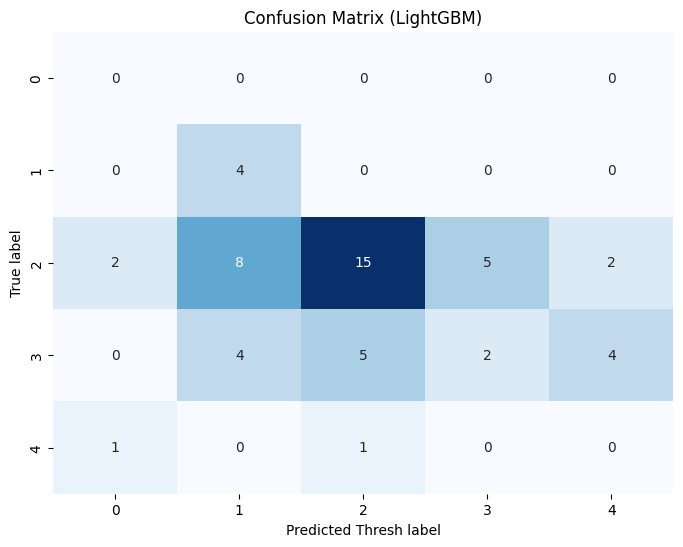

In [295]:
LightGBM = optimize_lightgbm(X_train, y_train, X_dev, y_dev, n_trials=100, random_state=42)
LightGBM.fit(X_train, y_train)

y_pred_lightgbm = LightGBM.predict(X_test)

print("F1 Score (weighted):", f1_score(y_test, y_pred_lightgbm, average='weighted'))

cm = confusion_matrix(y_test, y_pred_lightgbm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Thresh label')
plt.ylabel('True label')
plt.title('Confusion Matrix (LightGBM)')
plt.show()

## CatBoost

In [296]:
!pip install catboost

In [297]:
from catboost import CatBoostClassifier
def optimize_catboost(X_train, y_train, X_dev, y_dev, n_trials=100, random_state=42):
    best_model = None
    best_f1 = -1.0

    def objective(trial):
        nonlocal best_model, best_f1

        params = {
            'iterations': trial.suggest_int('iterations', 50, 200),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 1.0, log=True),
            'depth': trial.suggest_int('depth', 3, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 100, log=True),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'verbose': 0,
            'auto_class_weights': 'Balanced'
        }

        model = CatBoostClassifier(**params)
        model.fit(X_train, y_train, eval_set=[(X_dev, y_dev)], early_stopping_rounds=10, verbose=0)
        y_pred = model.predict(X_dev)
        f1 = f1_score(y_dev, y_pred, average='weighted')

        if f1 > best_f1:
            best_f1 = f1
            best_model = model

        return f1

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    return best_model

[I 2025-06-30 10:27:41,896] A new study created in memory with name: no-name-07e6831e-4bab-4f61-b14e-3210e12aa379
[I 2025-06-30 10:27:42,061] Trial 0 finished with value: 0.5168372690111821 and parameters: {'iterations': 155, 'learning_rate': 0.027654293032318956, 'depth': 4, 'l2_leaf_reg': 0.010816387019999504, 'border_count': 91}. Best is trial 0 with value: 0.5168372690111821.
[I 2025-06-30 10:27:42,189] Trial 1 finished with value: 0.3425765723638064 and parameters: {'iterations': 101, 'learning_rate': 0.27180321891560444, 'depth': 6, 'l2_leaf_reg': 0.01148926294100687, 'border_count': 236}. Best is trial 0 with value: 0.5168372690111821.
[I 2025-06-30 10:27:42,786] Trial 2 finished with value: 0.4409285796171042 and parameters: {'iterations': 108, 'learning_rate': 0.00263904796761254, 'depth': 10, 'l2_leaf_reg': 0.026197818975515597, 'border_count': 221}. Best is trial 0 with value: 0.5168372690111821.
[I 2025-06-30 10:27:42,880] Trial 3 finished with value: 0.42583383003551073 an

F1 Score (weighted): 0.5075099304865939


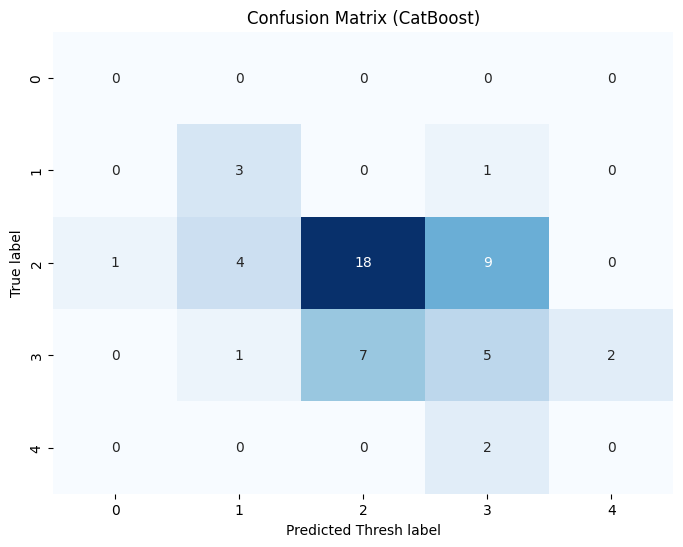

In [298]:
cboost = optimize_catboost(X_train, y_train, X_dev, y_dev, n_trials=100, random_state=42)
cboost.fit(X_train, y_train)

y_pred_cboost = cboost.predict(X_test)

print("F1 Score (weighted):", f1_score(y_test, y_pred_cboost, average='weighted'))

cm = confusion_matrix(y_test, y_pred_cboost)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Thresh label')
plt.ylabel('True label')
plt.title('Confusion Matrix (CatBoost)')
plt.show()

# Model validation

In [299]:
class_names = sorted(y_test.unique())

## Log-loss

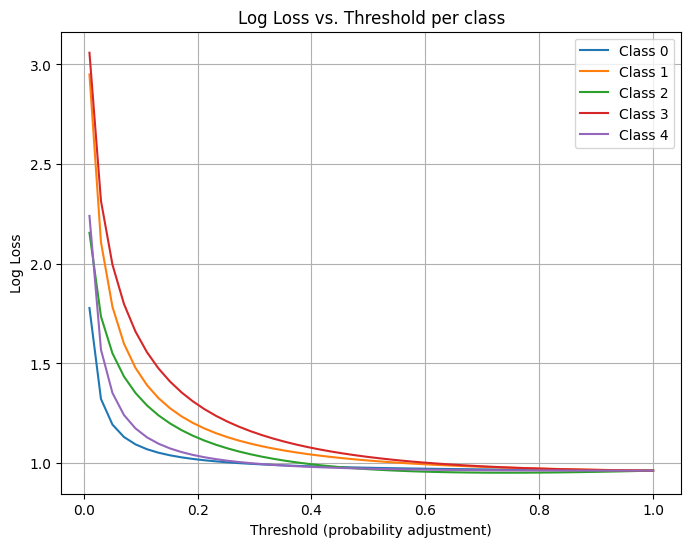

In [300]:
from sklearn.metrics import log_loss
import numpy as np
import matplotlib.pyplot as plt

def plot_log_loss_vs_threshold_multiclass_all_in_one(model, X_test, y_test):
    y_prob = model.predict_proba(X_test)
    n_classes = y_prob.shape[1]
    thresholds = np.linspace(0.01, 1.0, 50)

    plt.figure(figsize=(8, 6))
    for class_index in range(n_classes):
        log_losses = []
        for thresh in thresholds:
            adjusted_prob = y_prob.copy()
            adjusted_prob[:, class_index] = y_prob[:, class_index] / thresh
            adjusted_prob /= adjusted_prob.sum(axis=1, keepdims=True)
            adjusted_prob = np.clip(adjusted_prob, 1e-15, 1 - 1e-15)
            loss = log_loss(y_test, adjusted_prob, labels=np.arange(n_classes))
            log_losses.append(loss)

        plt.plot(thresholds, log_losses, label=f'Class {class_index}')
    plt.xlabel('Threshold (probability adjustment)')
    plt.ylabel('Log Loss')
    plt.title('Log Loss vs. Threshold per class')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_log_loss_vs_threshold_multiclass_all_in_one(single_svm, X_test, y_test)

#### **Class 0**:
- Đường cong log loss bắt đầu cao ở threshold thấp và giảm mạnh khi threshold tăng lên khoảng 0.1–0.2.
- Sau đó log loss gần như ổn định dưới mức 1.
- Điều này cho thấy mô hình dự đoán Class 0 **tương đối tốt** và chỉ cần hiệu chỉnh nhẹ threshold là đủ để đạt hiệu suất tốt.

#### **Class 1**:
- Có log loss khởi điểm cao hơn Class 0 và cần ngưỡng threshold lớn hơn (khoảng ~0.17) để đạt mức tối ưu.
- Mô hình có vẻ **kém tự tin hơn** trong việc nhận diện Class 1, đòi hỏi điều chỉnh mạnh tay hơn để cải thiện dự đoán.

#### **Class 2**:
- Đường cong log loss của Class 2 giảm nhanh chóng và đạt mức tối thiểu thấp hơn hầu hết các lớp khác.
- Điều này cho thấy mô hình có **hiệu suất rất tốt** với Class 2, khả năng nhận diện chính xác cao.
- Chỉ cần threshold nhỏ (~0.15) để tối ưu hóa log loss.

#### **Class 3**:
- Đây là lớp có **log loss cao nhất ban đầu** và giảm chậm hơn khi threshold tăng.
- Thậm chí tại threshold tối ưu (~0.2), log loss vẫn lớn hơn 1.
- Điều này phản ánh rằng Class 3 là **lớp khó phân loại nhất** đối với mô hình — dự đoán chưa đủ chính xác hoặc xác suất còn lệch.

#### **Class 4**:
- Đường cong log loss khá thấp và ổn định, với điểm tối ưu ở khoảng threshold ~0.1.
- Điều này cho thấy mô hình **đã học tốt** và **tự tin** trong việc phân loại Class 4, chỉ cần điều chỉnh rất nhẹ để đạt hiệu quả tối đa.

### Kết luận:
- **Class 3** cần được xem xét lại – có thể do mất cân bằng dữ liệu hoặc chưa có đủ đặc trưng phân biệt tốt.
- **Class 2 và Class 4** cho thấy hiệu suất tốt và ổn định – mô hình hoạt động hiệu quả trên các lớp này.
- Các lớp còn lại có thể hưởng lợi từ việc hiệu chỉnh ngưỡng xác suất (threshold tuning) hoặc calibration theo lớp để tối ưu hóa log loss.


## Viết hàm vẽ AUC-ROC

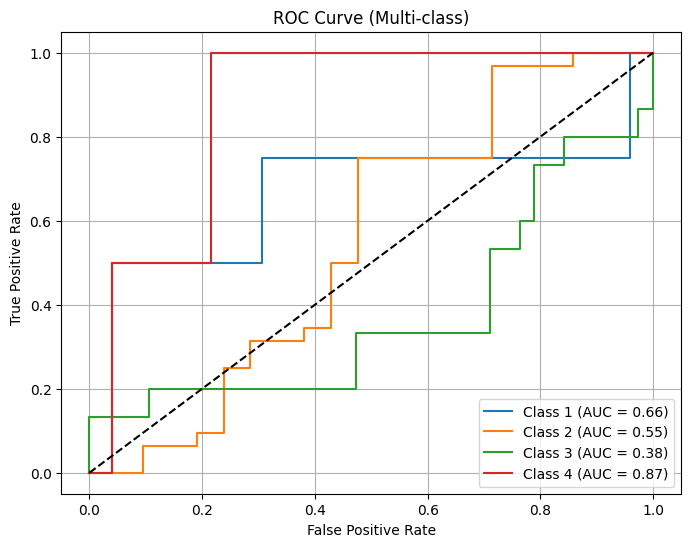

In [301]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_multiclass_roc_auc(model, X_test, y_test, class_names):
    y_score = model.predict_proba(X_test)
    y_bin = label_binarize(y_test, classes=class_names)

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Multi-class)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_multiclass_roc_auc(single_svm, X_test, y_test, class_names)

#### **Class 1 (AUC = 0.66)**
- Mô hình **phân biệt tương đối tốt** lớp này, nhưng vẫn còn có thể cải thiện.
- Đường cong vượt rõ lên trên đường chéo, cho thấy tín hiệu dự đoán vẫn có ý nghĩa.

#### **Class 2 (AUC = 0.55)**
- AUC chỉ nhỉnh hơn 0.5 một chút, cho thấy mô hình **gần như đoán ngẫu nhiên** đối với lớp này.
- Cần xem lại dữ liệu đầu vào, có thể lớp này bị **nhiễu hoặc thiếu đặc trưng rõ ràng**.

#### **Class 3 (AUC = 0.38)**
- AUC dưới 0.5, điều này cảnh báo **mô hình có thể đang học sai chiều phân biệt**, ví dụ: dự đoán ngược so với thực tế.
- Nên kiểm tra lại nhãn lớp hoặc phân phối dữ liệu lớp 3 để xác minh vấn đề.

#### **Class 4 (AUC = 0.87)**
- Hiệu suất **rất tốt**: mô hình phân biệt Class 4 với các lớp còn lại **rất rõ ràng**.
- Đây là lớp mà mô hình tự tin và chính xác nhất, xác suất dự đoán có độ tin cậy cao.

### Kết luận:
- **Class 4** là điểm mạnh của mô hình hiện tại.
- **Class 3** là điểm yếu nghiêm trọng – cần phân tích lại dữ liệu và tính năng đầu vào.
- **Class 2 và Class 1** cần được cải thiện thêm, có thể qua xử lý mất cân bằng dữ liệu (resampling), chọn đặc trưng (feature selection), hoặc điều chỉnh thuật toán.

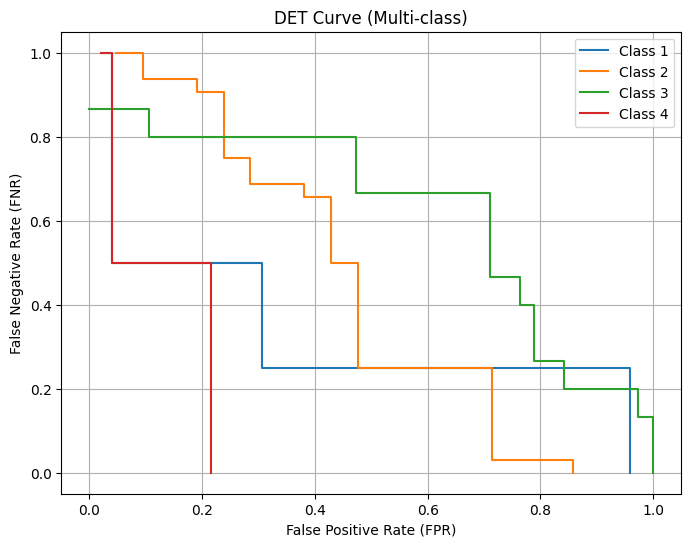

In [302]:
from sklearn.metrics import det_curve

def plot_multiclass_det(model, X_test, y_test, class_names):
    y_score = model.predict_proba(X_test)
    y_bin = label_binarize(y_test, classes=class_names)

    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):
        fpr, fnr, _ = det_curve(y_bin[:, i], y_score[:, i])
        plt.plot(fpr, fnr, label=f'Class {class_names[i]}')

    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('False Negative Rate (FNR)')
    plt.title('DET Curve (Multi-class)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_multiclass_det(single_svm, X_test, y_test, class_names)

#### **Class 1**
- Đường cong có xu hướng giảm về góc trái dưới, FPR và FNR đều có thể được đưa về thấp.
- Điều này cho thấy **mô hình dự đoán Class 1 khá cân bằng**, không quá nghiêng về bỏ sót hay báo nhầm.

#### **Class 2**
- Mặc dù ban đầu có FNR cao (~1.0), nhưng khi FPR tăng thì FNR giảm nhanh.
- Cho thấy nếu chấp nhận tăng FPR một chút, mô hình có thể **giảm đáng kể tỷ lệ bỏ sót** (FNR).
- Lớp này có **khả năng phân biệt trung bình**, nhưng có thể tinh chỉnh được.

#### **Class 3**
- Đường cong khá cao trên trục FNR, tức là mô hình **bỏ sót nhiều mẫu thuộc Class 3**, ngay cả khi FPR tăng.
- Mô hình có vẻ **khó khăn trong việc nhận diện chính xác Class 3**, đây là **lớp yếu nhất** tương tự như ROC-AUC đã chỉ ra trước đó.

#### **Class 4**
- Dù đoạn đầu FNR = 1, nhưng ngay sau đó giảm nhanh khi FPR tăng nhẹ.
- Đường cong nhanh chóng tiệm cận gốc (0,0) – cho thấy **mô hình phân biệt Class 4 rất tốt** khi điều chỉnh threshold hợp lý.
- Đây là **lớp mạnh nhất**, với khả năng kiểm soát tốt cả FPR và FNR.

### Kết luận:
- **Class 4** tiếp tục thể hiện là lớp dễ nhận diện, ít lỗi cả FPR lẫn FNR.
- **Class 3** tiếp tục là lớp yếu nhất, với tỷ lệ bỏ sót cao, cần được cải thiện qua dữ liệu hoặc tính năng.
- **Class 1 và 2** có hiệu năng trung bình, có thể tinh chỉnh threshold để đạt trade-off tốt hơn.

## Hiệu chỉnh để tăng Recall

In [313]:
from sklearn.svm import SVC
from sklearn.metrics import recall_score, f1_score
import optuna
import numpy as np

def optimize_svm_threshold_recall(X_train, y_train, X_dev, y_dev, n_trials=200, random_state=42):
    n_classes = len(np.unique(y_train))
    best_model = None
    best_recall = -1.0
    best_f1 = -1.0
    best_thresholds = None

    def objective(trial):
        nonlocal best_model, best_recall, best_thresholds, best_f1

        params = {
            'C': trial.suggest_float('C', 1e-3, 1e3, log=True),
            'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly']),
            'degree': trial.suggest_int('degree', 2, 5) if trial.suggest_categorical('use_poly', [True, False]) else 3,
            'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
            'probability': True,
            'random_state': random_state,
            'class_weight': 'balanced'
        }

        model = SVC(**params)

        try:
            model.fit(X_train, y_train)
            probas = model.predict_proba(X_dev)
        except Exception as e:
            return -1.0  # Trường hợp model fail

        # Threshold tối ưu cho từng lớp
        thresholds = [trial.suggest_float(f"thresh_class_{i}", 0.1, 1.0) for i in range(n_classes)]

        adjusted_preds = []
        for row in probas:
            adjusted = row / thresholds
            adjusted = adjusted / np.sum(adjusted)
            pred = np.argmax(adjusted)
            adjusted_preds.append(pred)

        recall = recall_score(y_dev, adjusted_preds, average='weighted')
        f1 = f1_score(y_dev, adjusted_preds, average='weighted')

        if recall > best_recall:
            best_model = model
            best_recall = recall
            best_thresholds = thresholds
            best_f1 = f1

        return recall

    sampler = optuna.samplers.TPESampler(seed=random_state)
    study = optuna.create_study(direction='maximize', sampler=sampler)
    study.optimize(objective, n_trials=n_trials)

    print(f"✅ Weighted Recall cao nhất: {best_recall:.4f}")
    print(f"📉 F1-score tương ứng: {best_f1:.4f}")
    print(f"🔧 Ngưỡng xác suất theo lớp: {np.round(best_thresholds, 3)}")

    return best_model, best_thresholds, best_recall

In [314]:
model, thresholds, recall = optimize_svm_threshold_recall(X_train, y_train, X_dev, y_dev)

# Áp dụng threshold vào X_test:
probas = model.predict_proba(X_test)
adjusted_preds = []
for row in probas:
    adjusted = row / thresholds
    adjusted = adjusted / np.sum(adjusted)
    pred = np.argmax(adjusted)
    adjusted_preds.append(pred)

print("📌 Recall (test):", recall_score(y_test, adjusted_preds, average='weighted'))
print("📌 F1-score (test):", f1_score(y_test, adjusted_preds, average='weighted'))


[I 2025-06-30 11:54:00,246] A new study created in memory with name: no-name-12951cb0-3687-4973-8fa3-48da2f6bb102
[I 2025-06-30 11:54:00,291] Trial 0 finished with value: 0.28846153846153844 and parameters: {'C': 0.1767016940294795, 'kernel': 'linear', 'use_poly': True, 'degree': 2, 'gamma': 'scale', 'thresh_class_0': 0.737265320016441, 'thresh_class_1': 0.1185260448662222, 'thresh_class_2': 0.9729188669457949, 'thresh_class_3': 0.8491983767203796, 'thresh_class_4': 0.29110519961044856}. Best is trial 0 with value: 0.28846153846153844.
[I 2025-06-30 11:54:00,329] Trial 1 finished with value: 0.19230769230769232 and parameters: {'C': 0.012329623163659839, 'kernel': 'poly', 'use_poly': True, 'degree': 4, 'gamma': 'auto', 'thresh_class_0': 0.4297256589643226, 'thresh_class_1': 0.5104629857953323, 'thresh_class_2': 0.8066583652537123, 'thresh_class_3': 0.2797064039425238, 'thresh_class_4': 0.5628109945722505}. Best is trial 0 with value: 0.28846153846153844.
[I 2025-06-30 11:54:00,356] Tri

✅ Weighted Recall cao nhất: 0.6346
📉 F1-score tương ứng: 0.4928
🔧 Ngưỡng xác suất theo lớp: [0.884 0.823 0.268 0.903 0.585]
📌 Recall (test): 0.6037735849056604
📌 F1-score (test): 0.4600179694519317


## Learning curves

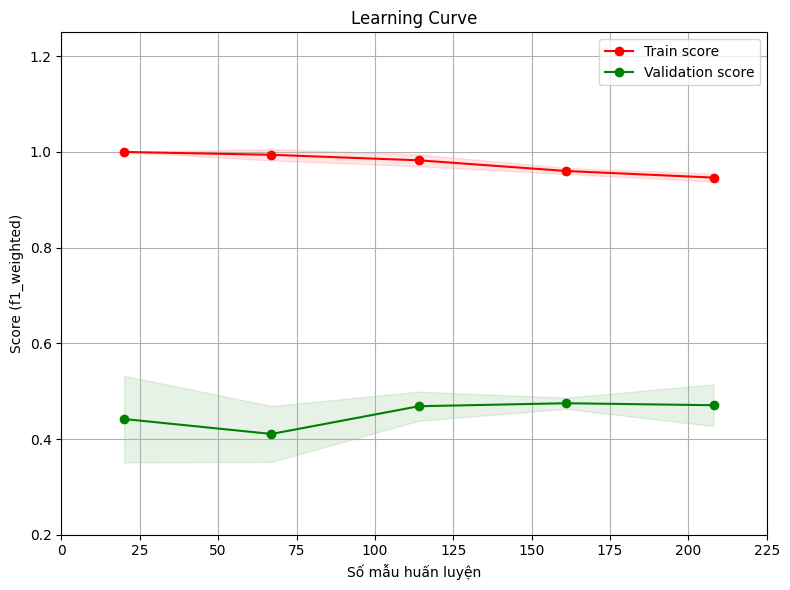

In [315]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, StratifiedKFold

def plot_learning_curve(estimator, X, y, title="Learning Curve",
                        scoring='f1_weighted', cv=5,
                        train_sizes=np.linspace(0.1, 1.0, 5),
                        n_jobs=-1, random_state=42):
    """
    Hàm vẽ learning curve cho một estimator.

    Parameters:
        estimator: mô hình huấn luyện (ví dụ: LogisticRegression(), SVC(), ...)
        X: features (ndarray hoặc DataFrame)
        y: labels
        title: tiêu đề đồ thị
        scoring: độ đo đánh giá (accuracy, f1_macro, ...)
        cv: số fold hoặc object chia tập cross-validation
        train_sizes: danh sách tỷ lệ dữ liệu huấn luyện dùng để vẽ (mặc định: từ 10% đến 100%)
        n_jobs: số lượng CPU để chạy song song (mặc định -1: dùng tất cả)
        random_state: để tái hiện được kết quả
    """

    if isinstance(cv, int):
        cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)

    train_sizes_abs, train_scores, test_scores = learning_curve(
        estimator, X, y,
        train_sizes=train_sizes,
        cv=cv,
        scoring=scoring,
        n_jobs=n_jobs,
        shuffle=True,
        random_state=random_state
    )

    train_scores_mean = train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)

    test_scores_mean = test_scores.mean(axis=1)
    test_scores_std = test_scores.std(axis=1)

    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.xlabel("Số mẫu huấn luyện")
    plt.ylabel(f"Score ({scoring})")
    plt.xlim(0, 225)
    plt.ylim(0.2, 1.25)
    plt.grid(True)
    plt.fill_between(train_sizes_abs,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1, color="r")
    plt.fill_between(train_sizes_abs,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1, color="g")
    plt.plot(train_sizes_abs, train_scores_mean, 'o-', color="r", label="Train score")
    plt.plot(train_sizes_abs, test_scores_mean, 'o-', color="g", label="Validation score")

    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

plot_learning_curve(model, X, y, scoring='f1_weighted', title="Learning Curve")